# 12. 메트릭과 증강을 활용한 훈련 개선
- 현재 곤경에 처해 있음. 딥러닝 프로젝트가 겨우 자리 잡았지만 쓸 만한 결과 없고 신경망은 모든 데이터를 결절이 아니라고 분류
- 음성 샘플에 지나치게 치우친 데이터 덕분에 모델이 높은 점수를 얻고자 단순히 모두 음성으로 판단

## 12.1 개선을 위한 상위 계획
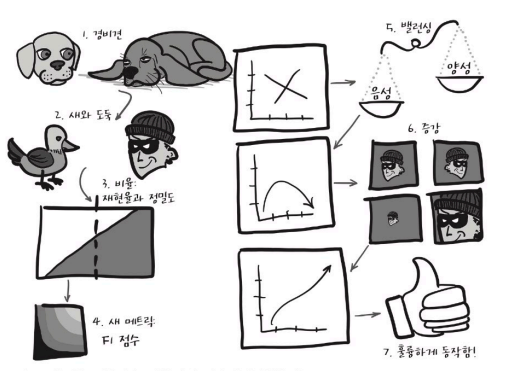  

- 훌륭한 동작을 위해 모델 측정 메트릭 수정 시 사용할 비유

앞서 11장에서 구현한 내용과 관련된 이슈를 논의할 때 필요한 핵심 개념을 표현하기 위한 (3)'비율: 재현율과 정밀도'라는 도식화된 언어가 필요

이 개념이 견고해지면 수학을 통해 이 개념으로 모델의 성능을 평가하고 캡슐화하여 지표를 (4)'F1 점수'라는 하나의 숫자로 압축

새로운 메트릭인 F1 점수를 위한 공식을 구현하고 훈련 에포크마다 어떻게 변하는지 확인해볼 것

마지막으로 훈련 결과 개선을 위해 LunaDataset을 (5)'밸런싱'과 (6)'증강'의 관점에서 대폭 수정

이렇게 실험을 통해 변경해보면서 성능 메트릭이 예상대로 반응하는지를 살펴볼 것

## 12.2 착한 개와 나쁜 녀석: 거짓 양성과 거짓 음성
- 한 마리는 무엇을 보면 다 짖는 반면, 다른 한 마리는 정확히 도둑을 봤을 때만 짖지만 자지 않을 때만 짖음
- 다 짖는 경우는 거짓 양성(false positive), 잘 짖지 않는 경우는 거짓 음성(false negative)
- 비유의 마지막으로, 11장의 모델은 기본적으로 참치 캔이 아닌 모든 것에 대해 야옹거리기를 거부하는 고양이임

## 12.3 긍정과 부정의 경우를 도식화하기
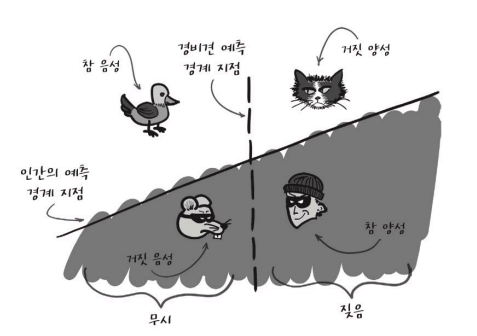

모델의 역할은 각 이벤트를 비롯해 관련 특성을 해당 사분면의 어딘가로 매핑하고, 수직선 하나로 양성과 음성을 분리하는 것

이 작업은 모델의 마지막에 놓인 nn.Linear가 수행함. 수직선의 위치는 11.6.1 절에서 살펴본 classificationThreshold_float과 정확히 일치

그 때는 0.5를 하드코딩하여 경계값으로 사용

실제로 데이터는 2차원으로 끝나지 않음. 두 번째부터 마지막 계층을 거치며 차원은 엄청나게 올라가고 출력단에서 다시 한 차원(x축)이 되어 각 샘플당 하나의(분류 경계롤 2등분되는)스칼라값이 됨.

여기에서 우리는 모델이 샘플에서 볼 수 없는 특징을 나타내는 두 번째 차원(y축)을 사용

이를테면 환자의 나이나 성별, 폐에서의 결절 후보 위치, 그리고 모델이 사용하지 않은 후보의 위치적 특성 등을 생각할 수 있음

이를 통해 결절이냐 아니냐의 모호한 경계까지도 표현할 수 있음

### 12.3.1 아무나 보고 짖는 룩시의 장점은 재현율
- 재현율(recall)은 기본적으로 '주의할 이벤트는 단 하나도 놓치지 마라!'는 의미임, 정확하게 재현율은 **참 양성과 거짓 음성의 합집합에 대한 양성의 비율**임 (상황에 따라 재현율은 민감도(sensitivity)라고도 부른다.)
- 재현율을 개선하려면 거짓 음성만 줄이면 됨. 즉, 확실하지 않으면 일단 짖고보자는 얘끼

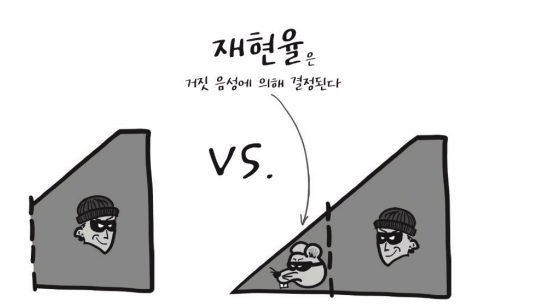

- 높은 재현율은 거짓 음성을 낮춘다.


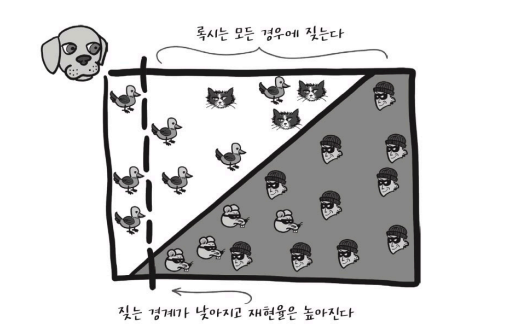

- 록시는 거짓 음성을 낮추는 걸 우선하여 경계 수준을 선택함. 록시는 쥐를 보기만 하면 짖는다. 사실, 고양이도, 대부분의 새도 예외는 아니다.

### 12.3.2 잠은 많아도 도둑은 잘 잡는 프레스톤의 특기는 정밀도
- 정밀도(precision)는 기본적으로 '확실한 것이 아니면 짖지 않기'다. 정밀도를 높이려면 거짓 양성을 낮춰야 함.
- 정의하자면 **참 양성과 거짓 양성의 합집합에 대한 참 양성의 비율**임

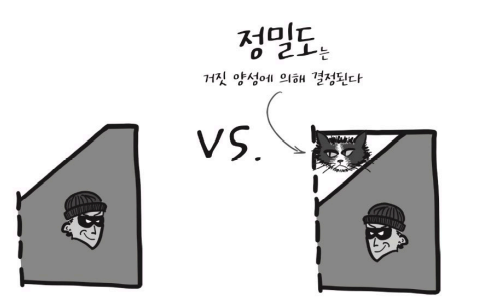

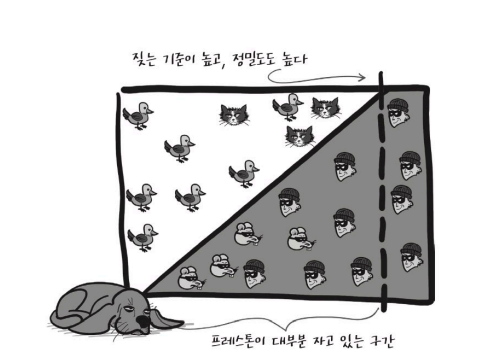

- 프레스톤은 분류 경계를 오른쪽 끝으로 밀어붙여서 관심 이벤트가 아닌 경우를 최대한 배제하고 이를 통해 매우 높은 정밀도를 달성

- 이 전략은 록시와 상반되는 것으로, 거의 1.0에 가까운 정밀도 나타냄

### 12.3.3 logMetircs으로 정밀도와 재현율 구하기
- 손실값과 정확도 메트릭에 각 에포크마다 정밀도와 재현율을 출력하도록 추가하기 위해 logmetrics 함수를 업데이트해보자

In [ ]:
        neg_count = int(negLabel_mask.sum())
        pos_count = int(posLabel_mask.sum())

        trueNeg_count = neg_correct = int((negLabel_mask & negPred_mask).sum())
        truePos_count = pos_correct = int((posLabel_mask & posPred_mask).sum())

        falsePos_count = neg_count - neg_correct
        falseNeg_count = pos_count - pos_correct

- 코드를 보면 neg_correct가 trueNeg_count와 같다. 결절이 아닌 경우에는 '음성'값이고('음성 판정'에서의 음성이다.), 만일 식별기가 정확하게 예측했다면 이 경우는 참 음성이다. 
- 그리고 거짓 양성과 거짓 음성 값을 위한 변수도 추가
- 이 값으로 precision과 recall을 계산하고 metrics_dict에 넣음

In [ ]:
        precision = metrics_dict['pr/precision'] = \
            truePos_count / np.float32(truePos_count + falsePos_count)
        recall    = metrics_dict['pr/recall'] = \
            truePos_count / np.float32(truePos_count + falseNeg_count)

### 12.3.4 궁극의 메트릭: F1 점수
- 정밀도와 재현율을 합치는 일반적인 방법으로 F1 점수를 사용
- 다른 메트릭처럼 F1 점수는 0과 1사이의 값(0은 분류기의 예측 성능이 없는 상태이며, 1은 분류기가 완벽하게 예측하는 상태)
- logMetrics에서 이 값도 포함하도록 수정
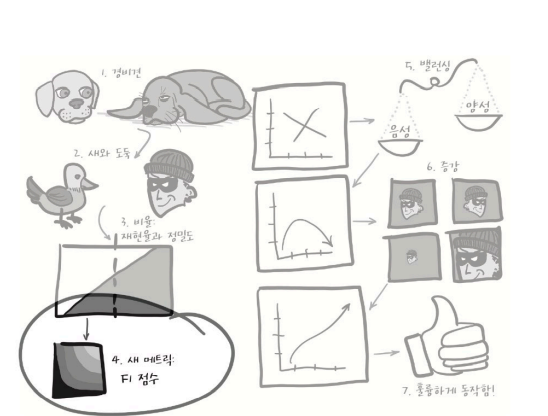

In [ ]:
        metrics_dict['pr/f1_score'] = \
            2 * (precision * recall) / (precision + recall)

필요 이상으로 복잡해 보이며, F1 점수가 어떻게 정밀도와 재현율을 모두 고려하여 동작하는지 분명하게 알기도 어렵다.

하지만 이 공식에는 여러 좋은 특성이 있으며, 우리가 고려하는 더 단순한 대안에 비해 훨씬 더 유리함

쉽게 생각할 수 있는 다른 지표는 정밀도와 재현율을 평균하는 방법. 하지만 정밀도나 재현율 둘 중 하나가 0인 경우는 쓸모없는 경우인데 다른 하나의 값이 1이라면 평균은 똑같이 0.5가 나오므로 의미있는 메트릭으로 사용할 만하지 않음

_____

평균값과 F1 점수를 눈으로 비교하면,

    1) 평균값 그래프에서는 꺾인 곡선을 볼 수 없다.이 때문에 평균값 그래프에서는 정밀도나 재현율이 한쪽으로 치우칠 수 있음
    2) F1점수를 보게되면, 재현율은 높지만 정밀도가 낮은 상황이라면, 팔꿈치 모양의 굽은 곡선 덕분에, 정밀도를 조금만 높게 움직여도 재현율이 급격히 떨어지며 두 값이 균형을 찾는 지점으로 이동

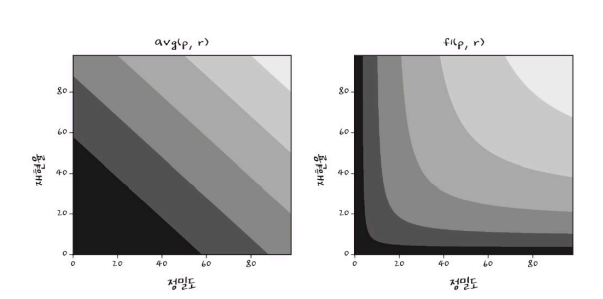

____
이번에는 한쪽으로 치우치는 경우에 대한 보상이 전혀 없다고 가정,
정밀도와 재현율의 최솟값을 취해보자

최솟값과 F1점수를 눈으로 비교하면,

    좋은 부분이 있다. 둘 중 하나의 값이 0이면 점수도 0이다. 그리고 점수 1.0이 되려면 두 값 모두 1.0이어야 함. 하지만 부족한 점도 있음. 정밀도를 0.5로 고정할 채 재현율을 0.7에서 0.9로 끌어올린 경우 점수 값 변하지 않음, 반대로 0.6로 떨어져도 변하지 않음
    
최솟값 메트릭은 재현율이나 정밀도가 불균형을 이룰 때 불이익을 주긴 하지만, 두 값의 미묘한 차이를 잡아내지 못함    

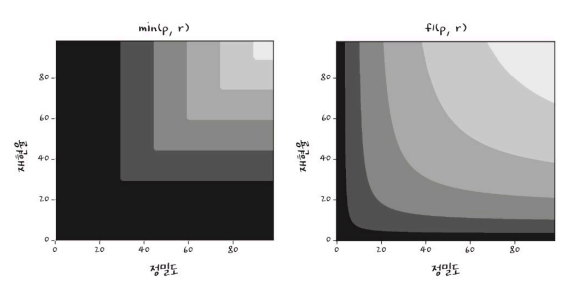

____
이 메트릭은 (0,0)에서 (0.5,0.5)까지의 사분면이 거의 0에 가깝다는 단점 있음

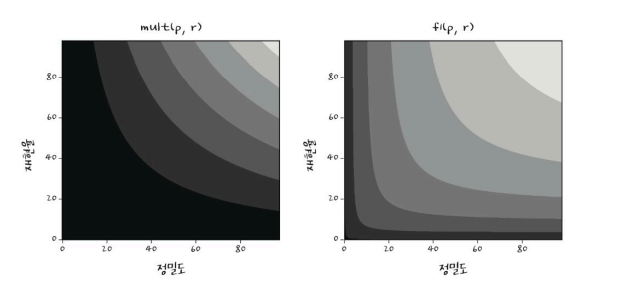

In [ ]:
# 정밀도, 재현율, F1 점수를 모두 포함하도록 로깅 출력 개선하기
log.info(
            ("E{} {:8} {loss/all:.4f} loss, "
                 + "{correct/all:-5.1f}% correct, "
                 + "{pr/precision:.4f} precision, "
                 + "{pr/recall:.4f} recall, "
                 + "{pr/f1_score:.4f} f1 score"
                         ).format(
                epoch_ndx,
                mode_str,
                **metrics_dict,
            )
        )

In [ ]:
# 추가로 각 음성과 양성 샘플에 대해 전체 샘플 수와 정확하게 식별한 경우의 수도 포함
log.info(
            ("E{} {:8} {loss/neg:.4f} loss, "
                 + "{correct/neg:-5.1f}% correct ({neg_correct:} of {neg_count:})"
            ).format(
                epoch_ndx,
                mode_str + '_neg',
                neg_correct=neg_correct,
                neg_count=neg_count,
                **metrics_dict,
            )
        )

### 12.3.5 새 메트릭으로 모델이 잘 동작하는지 확인하기


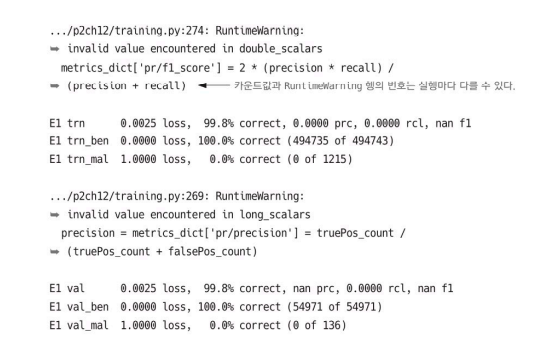

경고 메시지 있고, 계산한 값 중에는 nan도 있다. 어디선가 0으로 나누기를 수행한 것 같음

- 훈련셋의 양성 샘플은 실제 양성으로 분류된 케이스가 하나도 없음, 즉 정밀도와 재현율이 모두 0이며, F1 점수를 구하려다 0으로 나누는 실수를 하고 있음
- 검증셋을 보면 아무것도 양성으로 분류되지 않아서 검증셋에 대한 truePos_count와 falsePos_count가 둘 다 0, 결국 precision 계산의 분모도 0이 됨. 이래서 결국 RuntimeWarning 메시지까지 보게 된 것

몇 안 되는 음성 훈련 샘플은 양성으로 분류됐음. 첫 번째 배치는 랜덤한 결과를 만들어내므로 첫 배치에서 몇 개의 샘플을 양성으로 분류하는 것은 놀라운 일이 아님

## 12.4 이상적인 데이터셋의 모습
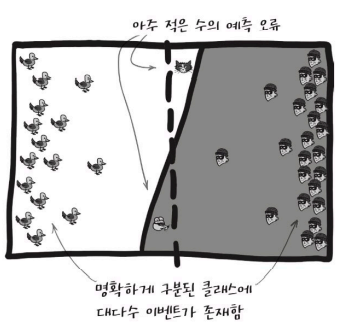

레이블의 경계와 분류 경계가 꽤 잘 만들어진 상황

그리고 대부분의 샘플이 다이어그램의 양쪽 경계에 집중되어 있음

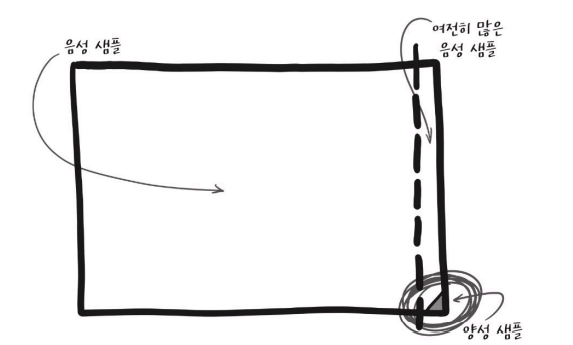

우리의 데이터를 보게되면, 꽤 불균형한 상태임

양성 샘플과 음성 샘플이 400:1의 비율을 보임

이런 조건이라면 '실제 결절' 샘플은 대량의 다른 데이터에 묻혀 잃어버렸다고 해도 과언이 아님

마음 같아서는 데이터 밸런싱 없이 모델을 계속 훈련시키고 싶을지도 모르지만 그러려면 엄청난 수의 에포크를 기다릴 수 있어야 함

### 12.4.1 데이터를 실제보다 '이상'에 가깝게 만들기

최선은 더 많은 양성 샘플을 확보하는 것이다.

신경망의 가중치는 랜덤값으로 초기화되므로 같은 샘플에 대한 신경망의 출력값 역시 랜덤이다.

예측값이 레이블 결과와 가깝다면 이로 인한 신경망 가중치 변화량은 크지 않다. 

반대로 정답과 거리가 먼 예측값은 가중치를 크게 조절한다.

모델이 랜덤 가중치일 때 출력도 랜덤이므로, 대략 50만 개의 훈련 샘플에 대해 다음 그룹을 가정해보자.

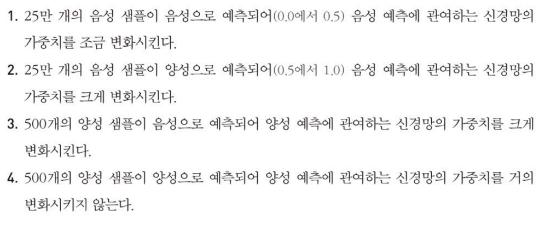

그룹2는 그룹3보다 대략 500배 크고 현재 배치 크기는 32이므로 500/32 = 15 즉 15개의 배치마다 겨우 한 개의 양성 샘플을 볼 수 있다.

15개의 훈련 배치 중 14개가 100% 음성 샘플이니, 모델의 가중치는 음성을 예측하도록 유도될 수밖에 없다.

**이렇게 하지 말고 음성 샘플 수만큼 양성 샘플을 늘려보자**

LUNA 데이터에는 소수의 양성 샘플만 존재하므로, 이 양성 샘플을 가지고 있다가 훈련 시 반복해서 모델에 노출시키자

파이토치를 사용한 배치 시스템은 모델로 하여금 패턴은 '파악'하거나 사용하지 못하게 해야 한다.

- 샘플러로 데이터셋 재구성하기

DataLoader의 옵션 인자로 sampler=...가 있다. 이 옵션으로 데이터 로더에 전달된 데이터의 원래 순회 순서를 무시하고 데이터의 차원 정보나 제한 등을 원하는 대로 바꿀 수 있다.

다만 이렇게 샘플러를 사용해 다양한 변형을 가하면 데이터셋 캡슐화를 깨뜨리는 단점이 있다.

Dataset API는 서브클래스가 len 과 getitem 만 제공하면 되도록 지정하고 있다. 이 API에 '어떤 샘플이 비행기인지?'라고 직접 물어볼 방법은 없다. 샘플의 부류를 물어보려면 먼저 모든 샘플을 로딩해야 한다. 아니면 데이터 캡슐화를 무시한 채 Dataset 서브클래스의 내부 구현을 봐가며 찾을 수 있다.

두 가지 방법 모두 데이터셋을 직접 제어하는 수단으로는 **이상적이지 않다.**

2분에서 보여주는 코드는 필요한 데이터 변형을 **Dataset 서브클래스에 구현했으며 외부 샘플러에 의존하지 않았다.**

- 데이터셋의 클래스 밸런싱 구현하기

지금은 LunaDataset을 직접 수정하여 훈련을 위한 양성과 음성 샘플이 1대1로 균형 잡히도록 만든다.

음성 훈련 샘플 리스트와 양성 훈련 샘플 리스트를 분리해서 유지하는 상태에서 각각의 리스트에서 넘어오는 샘플을 번갈아 사용한다.

이렇게 해서 모델이 보이는 모든 샘플에 대해 '거짓'으로 답해서 좋은 평가를 받는 나쁜 상황을 차단한다.

ratio_int를 LunaDataset에 더해서 N번째 샘플 레이블을 제어하고 레이블로 구분되는 샘플을 관리할 수 있게 하자

In [ ]:
class LunaDataset(Dataset):
    def __init__(self,
                 val_stride=0,
                 isValSet_bool=None,
                 series_uid=None,
                 sortby_str='random',
                 # ratio_int
                 ratio_int=0,
                 augmentation_dict=None,
                 candidateInfo_list=None,
            ):
        self.ratio_int = ratio_int
        self.augmentation_dict = augmentation_dict
        
        ###
        
        self.negative_list = [
            nt for nt in self.candidateInfo_list if not nt.isNodule_bool
        ]
        self.pos_list = [
            nt for nt in self.candidateInfo_list if nt.isNodule_bool
        ]
        
        ###
        
    # 매 에포크의 시작점에서 이 메소드를 호출하여 샘플 순서를 랜덤하게 만든다
    def shuffleSamples(self):
        if self.ratio_int:
            random.shuffle(self.negative_list)
            random.shuffle(self.pos_list)

ratio_int를 2로 놓아 음성 샘플과 양성 샘플의 비율을 2:1로 만든다면 모든 세 번째 인덱스는 양성이어야 된다

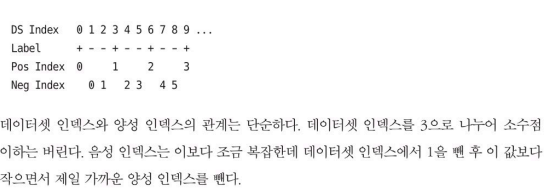

이를 코드로 구현한 것은 다음과 같다.


In [ ]:
    def __getitem__(self, ndx):
        if self.ratio_int: # ratio_int 가 0이면 값이 고르게 분포되는 것
            pos_ndx = ndx // (self.ratio_int + 1)

            if ndx % (self.ratio_int + 1): # 나머지가 0이 아니면 음성샘플
                # 음성샘플
                neg_ndx = ndx - 1 - pos_ndx
                neg_ndx %= len(self.negative_list)
                candidateInfo_tup = self.negative_list[neg_ndx]
            else:
                # 양성샘플
                pos_ndx %= len(self.pos_list)
                candidateInfo_tup = self.pos_list[pos_ndx]
        else:
            candidateInfo_tup = self.candidateInfo_list[ndx]


비율을 낮게 잡으면 데이터셋을 다 돌기 전에 양성 샘플을 다 써버린다.

그래서 self.pos_list에 인덱싱하기 전에 nos_ndx에 모듈러 연산을 적용한다.

neg_ndx는 음성 샘플 수가 많으므로 오버플로가 발생하지 않지만, 상관없이 모듈러 연산을 적용해 추후 변경으로 발생할지 모르는 오버플로 대바한다.

추가로, 데이터셋의 길이도 바꿀 예정이다. 이렇게 해서 개별 에포크의 속도를 높일 수 있다. len을 200000으로 하드코딩하자

In [ ]:
    def __len__(self):
        if self.ratio_int:
            return 200000
        else:
            return len(self.candidateInfo_list)

여기에 명령행 파라미터까지 넣어서 완벽하게 만들자

In [ ]:
class LunaTrainingApp:
    def __init__(self, sys_argv=None):
        
        ###
        
        parser.add_argument('--balanced',
            help="Balance the training data to half positive, half negative.",
            action='store_true',
            default=False,
        )

파라미터는 LunaDataset 생성자에 전달

In [ ]:
    def initTrainDl(self):
        train_ds = LunaDataset(
            val_stride=10,
            isValSet_bool=False,
            ratio_int=int(self.cli_args.balanced),
            augmentation_dict=self.augmentation_dict,
        )

### 12.4.2 균형잡힌 LunaDataset으로 훈련시킨 결과의 차이

- --balanced로 돌린 결과는 다음과 같다.

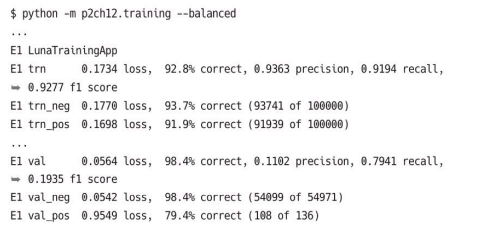

음성 샘플에 대한 정확도 5%를 손해보는 대신 양성에 대해 86%의 정확도를 얻었다.

하지만, 11장에서와같이 결과가 다소 의심스럽다.

양성 샘플에 대해 음성 샘플이 400배나 많으므로, 1%만 잘못 분류되어도 음성 샘플을 양성으로 잘못 판단한 경우는 전체에서 실제 양성 샘플이 있는 경우보다 네 배나 더 많다는 의미다.

95%의 거짓 양성을 걸러내는 걸러내는 작업을 도울 수 있다

그러나 양성 샘플의 14%를 놓친 성가신 이슈가 남아있다.

추가적인 에포크 훈련이 도움이 될 수 있다.

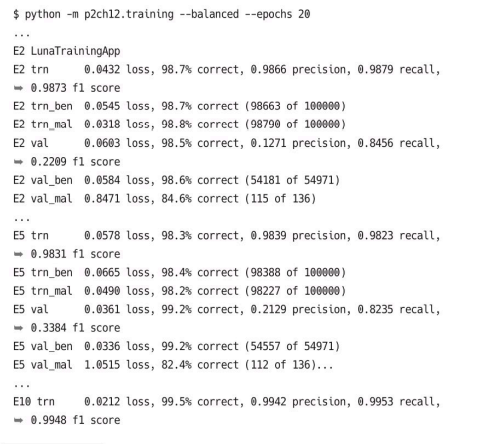

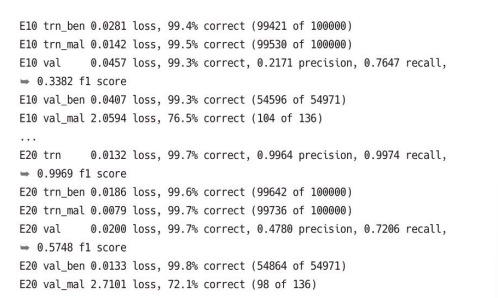

val_mal xx.x% correct 수치에 주목하면

에포크 2를 지나면 87.5%가 되고 5를 넘어서면 92.6%까지 올라간 후 에포크20에서 86.8%로 두 번째 에포크보다 낮아진다.

훈련셋 수에서 동일한 문제가 있는 것 같지는 않다. 음성 훈련 샘플은 98.8%의 정확도로 분류되고 양성 샘플은 99.1%가 정확하다. 무슨 의미일까?

### 12.4.3 과적합 증상 알아채기
우리가 보고 있는 것은 전형적인 과적합 현상이다.
각 양성 훈련 샘플은 거의 완벽하게 예측하고 있다. 반면 양성 샘플에 대한 검증 손실은 점점 증가한다. 즉 실세계에서의 모델 성능은 점점 나빠지고 있다.

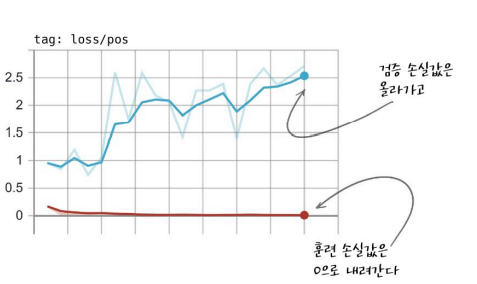

이때는 올바른 메트릭을 살펴봐야 한다. 현재 이 경향은 양성 손실값에서만 나타나고 있다.

이런 상황이 발생하는 이유는 우리의 검증셋이 균형잡히지 않았기 때문이다. 이 때문에 전체 손실값이 음성 샘플에 의해 좌지우지된다.

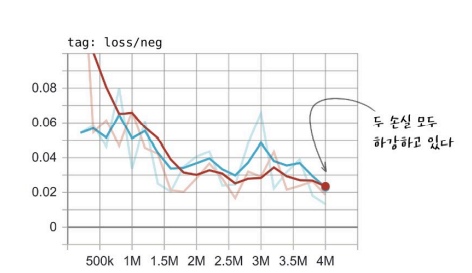

그림에서도 알 수 있듯이, 음성 샘플에 대해서는 이렇게 서로 갈라지는 모습을 볼 수 없다.

당연하게도 음성 샘플을 400배나 많이 가지고 있으므로 모델이 개별 샘플에 대한 세부 내용을 기억하기 어렵기 때문이다.

양성 훈련셋은 겨우 1215개의 샘플만 있다.

모델은 학습을 통해 일반화된 원리를 배우는 대신 1215개의 샘플을 외워버리고 이 샘플에 해당하지 않는 건 다 음성이라고 판단해버린다.

다만 양성 검증셋의 70% 정도는 구별하므로 일반화는 어느 정도 계속 진행되고 있다.

훈련셋이나 검증셋 모두에 대해 옳은 방향으로 진행하도록 만들려면 모델의 훈련 방법만 바꾸면 된다.

## 12.5 과적합 문제 다시 살펴보기
모델이 훈련셋으로부터 어떤 '특성'을 배우기 시작할 때 과적합이 발생하면 모델은 일반화하는 능력을 잃어버린다.

너무 추상적일 수 있으니, 비유를 하나 들어보겠다.
### 12.5.1 과적합된 얼굴-나이 예측모델
과적합 모델은 특정 인물들의 식별된 세부사항을 기억해서 그 사람 자체를 외워버린다.

새로운 인물이 등장하면 모델은 누구인지 알 수 없으니 나이를 전혀 예측할 수 없다.

과적합(overfitting)은 모델이 가진 능력에 비해 너무 적은 수의 훈련 샘플이 주어질 때 답을 외어버리면서 발생한다.

## 12.6 데이터 증강으로 과적합 방지하기
모델 훈련을 적절한 수준에서 뛰어난 수준으로 높일 때가 왔다.
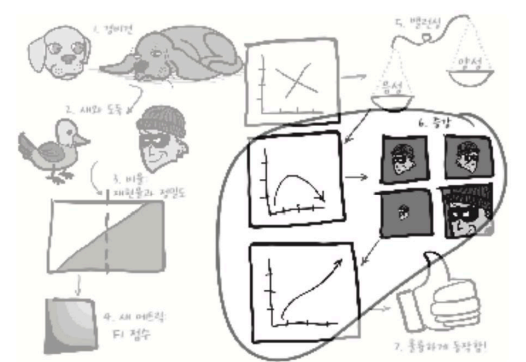

개별 샘플에 대한 합성을 통해 원래보다 많은 **새로운 데이터셋을 만들어** 데이터셋을 증강(augment)시키고 훈련 효과를 높여보자.\

데이터 증강을 통해 원본 샘플에 있는 클래스가 가진 일반적인 특성을 동일하게 유지한 합성 샘플을 만들어 모델이 외우지 못하게 만든다.

### 12.6.1 특별 데이터 증강 기술
5가지 특별한 데이터 증강 기술에 대해 알아보자.
- 이미지를 위-아래 혹은 좌-우 혹은 앞-뒤로 반전한다.
- 이미지를 몇 복셀만큼 평행이동시킨다.
- 이미지를 확대 또는 축소한다.
- 머리-발 축을 중심으로 이미지를 회전한다.
- 이미지에 노이즈를 추가한다.

결절 후보가 들어있는 원본 CT데이터 덩어리를 가져와 수정함 함수로 getCTAugmentedCandidate를 정의한다.

아핀 변환 행렬(affine transformation matrix)을 정의하고 파이토치의 affine_grid, grid_sample을 함께 사용하여 후보 샘플을 다시 만든다.

In [ ]:
def getCtAugmentedCandidate(
        augmentation_dict,
        series_uid, center_xyz, width_irc,
        use_cache=True):
    if use_cache:
        ct_chunk, center_irc = \
            getCtRawCandidate(series_uid, center_xyz, width_irc)
    else:
        ct = getCt(series_uid)
        ct_chunk, center_irc = ct.getRawCandidate(center_xyz, width_irc)

    ct_t = torch.tensor(ct_chunk).unsqueeze(0).unsqueeze(0).to(torch.float32)

먼저 직접 CT를 로딩하거나 캐시로부터 ct_chunk를 얻은 후 텐서로 변환한다.

다음은 아핀 그리드와 샘플링 코드다.



In [ ]:
    transform_t = torch.eye(4)
    
    ### 이 쯤에서 transform_tensor를 수정한다.
    
    affine_t = F.affine_grid(
            transform_t[:3].unsqueeze(0).to(torch.float32),
            ct_t.size(),
            align_corners=False,
        )

    augmented_chunk = F.grid_sample(
            ct_t,
            affine_t,
            padding_mode='border',
            align_corners=False,
        ).to('cpu')
    
    ###
    
    return augmented_chunk[0], center_irc

#### 미러링

샘플을 미러링할 때 픽셀값은 그대로 두고 이미지의 오리엔테이션만 바꾼다.

종양의 성장에 좌-우 앞-뒤 방향은 강한 상관관계가 없으므로 샘플을 대표하는 특성을 바꾸지 않고 이미지를 반전시킬 수 있어야 한다.

하지만 인덱스 축(환자 좌표에서 z로 나타나는 축)은 사람이 서 있을 때 중력 방향과 일치하므로, 종양의 위 아래에 차이가 있을 가능성이 있다.

임상의학과 연관된 프로젝트이므로 이 점은 전문가로부터 확인받을 필요가 있다.

In [ ]:
    for i in range(3):
        if 'flip' in augmentation_dict:
            if random.random() > 0.5:
                transform_t[i,i] *= -1

grid_sample 함수는 [-1,1] 범위를 이전 텐서와 새 텐서 모두에 매핑한다. 범위 매핑으로 데이터를 미러링하기 위해 변환 행렬의 관련 요소에 -1을 곱하기만 하면 된다.

#### 랜덤 크기만큼 평행이동시키기
컨볼루션은 평행이동에 독립적이므로 결절 후보를 평행이동하면 비록 모델은 센터에 맞춰지지 못했어도 잘 분류해 내겠지만 분류 성능에는 큰 차이를 주지 못한다. 오프셋이 복셀 단위의 정수가 아닌 경우에 더 두드러진 차이를 만들 수 있다.

삼중 선형 보간법(trilinear interpolation)을 사용하여 약간의 흐림(blur)처리가 들어가는 형태로 데이터는 다시 샘플링된다.

> Interpolation(인터폴레이션, 보간)이란 알려진 지점의 값 사이(중간)에 위치한 값을 알려진 값으로부터 추정하는 것을 말한다.


샘플의 경계에 있는 복셀은 반복되므로 경계를 따라 얼룩진 줄무늬처럼 보이게 된다.

In [ ]:
    for i in range(3):
        ###

        if 'offset' in augmentation_dict:
            offset_float = augmentation_dict['offset']
            random_float = (random.random() * 2 - 1)
            transform_t[i,3] = offset_float * random_float

'offset' 파라미터는 그리드 샘플 함수가 기대하는 [-1,1] 범위와 같은 비율로 표시되는 최대 오프셋이다.

#### 확대축소
이미지의 크기를 살짝 확대축소하는 것은 미러링이나 평행이동과 유사하다. 샘플 평행이동 때 설명했던 것과 마찬가지로, 경계 복셀이 반복되는 효과를 가진다.

In [ ]:
    for i in range(3):

        ###
            
        if 'scale' in augmentation_dict:
            scale_float = augmentation_dict['scale']
            random_float = (random.random() * 2 - 1)
            transform_t[i,i] *= 1.0 + scale_float * random_float

random_float는 [-1,1] 범위로 변환되므로 scale_float * random_float를 더하거나 1.0에서 빼는 것에 영향받지 않는다.

#### 회전
샘플이 변환할 때 원래 샘플이 표현하는 특성을 해치지 않도록 주의해야 하는데, 바로 회전이 이를 고려한 첫 번째 데이터 증강 기법이다.

우리가 만든 CT 단면은 행과 열을 따라 간격이 균일하지만 인덱스 방향(z축)은 다르기에 복셀은 정육면체가 아니다.

즉 x축과 y축은 z축과 호환될 수 없음을 의미한다.

따라서 가능한 방법으로 인덱스 축에 대해 다른 두 축과 동일하게 해상도를 조절하게끔 샘플을 만들 수 있따.

하지만 이러면 이 인덱스 축을 따르는 데이터는 매우 흐리고 얼룩지게 된다. 

따라서 이 인덱스 축은 특별한 것으로 간주하고 X-Y축으로만 고정한다.

In [ ]:
    if 'rotate' in augmentation_dict:
        angle_rad = random.random() * math.pi * 2
        s = math.sin(angle_rad)
        c = math.cos(angle_rad)

        rotation_t = torch.tensor([
            [c, -s, 0, 0],
            [s, c, 0, 0],
            [0, 0, 1, 0],
            [0, 0, 0, 1],
        ])

        transform_t @= rotation_t

#### 노이즈 
노이즈는 앞서 소개한 기술과는 차이가 있다.

이미지를 단순히 뒤집거나 회전하는 식이 아니라 실제로 샘플을 어느 정도 망가뜨리기 때문이다. 

In [ ]:
    if 'noise' in augmentation_dict:
        noise_t = torch.randn_like(augmented_chunk)
        noise_t *= augmentation_dict['noise']

        augmented_chunk += noise_t

이전의 증강 기술은 데이터셋의 크기를 키운 반면, 노이즈는 모델의 분류를 더 어렵게 만든다.

#### 증강된 후보 살펴보기
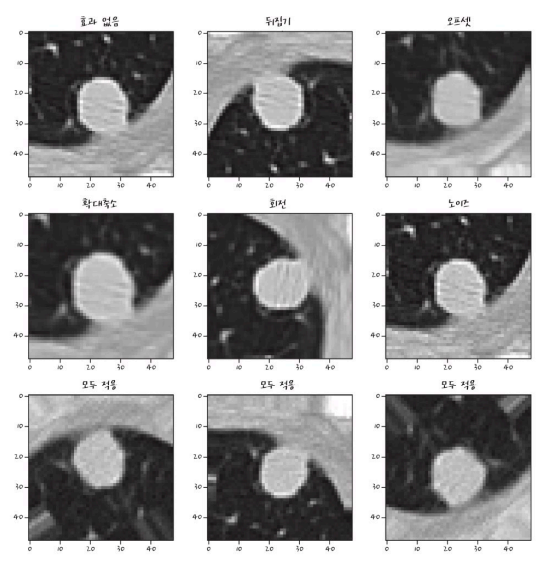

### 12.6.2 데이터 증강 효과 확인하기
각 증강 타입을 켜거나 끄기 위해 augmentation_dict 생성 부분을 명령행에 노출할 필요가 있다.

프로그램 인자는 parser.add_argument 호출을 통해 추가하여 augmentation_dict를 만든다.

In [ ]:
    self.augmentation_dict = {}
        if self.cli_args.augmented or self.cli_args.augment_flip:
            self.augmentation_dict['flip'] = True
        if self.cli_args.augmented or self.cli_args.augment_offset:
            self.augmentation_dict['offset'] = 0.1 # 이 값들은 적당한 영향을 주기 위해 경험에서 나온 것이며 더 좋은 값이 존재할 수 있다.
        if self.cli_args.augmented or self.cli_args.augment_scale:
            self.augmentation_dict['scale'] = 0.2
        if self.cli_args.augmented or self.cli_args.augment_rotate:
            self.augmentation_dict['rotate'] = True
        if self.cli_args.augmented or self.cli_args.augment_noise:
            self.augmentation_dict['noise'] = 25.0

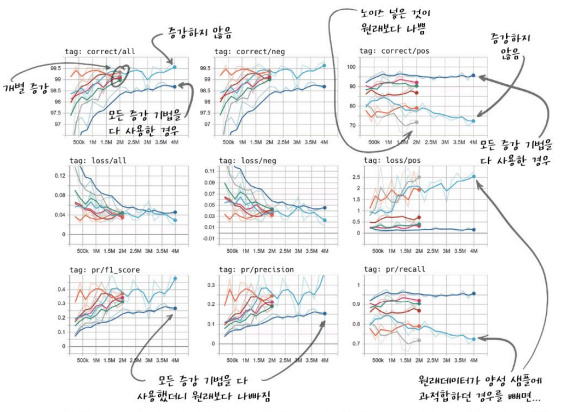

증강 타입을 섞었을 때가 각각의 합보다 효과가 크다.

하지만 전체 증강 유형을 섞은 경우 오답률이 높아진다.

일반적으로는 나쁘지만 제일 오른쪽 열의 이미지를 보면(우리가 집중하고 있는 실제 결절에 해당하는 양성 후보 샘플에 집중해서 보면)

모든 증강을 다 사용할 때가 양성 후보 샘플을 찾아내는 데 훨씬 나아 보인다.

과적합 면에서도 원래 모델은 시간이 지날수록 나빠지지만 전체 증강을 사용한 모델은 좋아진다.

특이한 점으로는 회전 증강을 사용한 모델이 재현율과 정밀도 면에서 전체 증강을 사용한 모델만큼 좋다는 점이다.

F1점수도 제한적인 점은 있지만 회전 증강에서 더 나은 점수를 보여준다.

우리 프로젝트는 높은 재현율을 요구하므로 전체 증강을 사용한 모델을 사용한다.

얼마의 에포크를 사용할 때 최선일지는 F1점수를 사용한다. 

실제 프로젝트에서는 더 나은 결과를 위해 어떤 증강 타입을 골라 섞어 사용하고, 어떤 파라미터 값을 사용해야 할지를 추가로 조사해볼 수 있다.

## 12.7 결론
충분하지 않은 데이터 소스를 어떻게 다뤄야 하는지도 배웠다. 

특성이 보존된 훈련 샘플을 합성해내는 것은 매우 유용하다.

이제 어느 정도 동작하는 분류기를 만들었으니, 분류할 결절 후보군을 자동으로 찾을 방법에 시선을 돌려보자.

그 다음 14장에서는 13장에서 만들 분류기준에 결절 후보들을 다시 넣어 결절이 양성인지 악성인지를 구분하도록 만들 예정이다.